In [3]:
import numpy as np
import matplotlib.pyplot as plt

#dynamics dx/dt = A*x + u

# environment parameters
dt = 0.1
A = -2.0  
x_desired = 1.0

u_min, u_max = -4.0, 4.0
du = 0.2  

#discretization for tabular Q
x_bins = np.linspace(-3.0, 3.0, 61) 
u_bins = np.linspace(u_min, u_max, 41) 


def discretize(val, bins):
    # returns index of nearest bin
    return int(np.digitize([val], bins)[0]) - 1

def state_id(x, u):
    ix = np.clip(discretize(x, x_bins), 0, len(x_bins)-1)
    iu = np.clip(discretize(u, u_bins), 0, len(u_bins)-1)
    return ix * len(u_bins) + iu


n_states = len(x_bins) * len(u_bins)
n_actions = 3  # [decrease, hold constant, increase]

# --- Q-learning hyperparams ---
alpha = 0.1
gamma = 0.98
epsilon = 0.5
epsilon_min = 0.01
epsilon_decay = 0.9995
n_episodes = 10000
max_steps = 200

# initialize Q-table
Q = np.zeros((n_states, n_actions))

# reward function
def reward(x, action, act_penalty=0.01):
    return -abs(x - x_desired) - (act_penalty if action != 1 else 0.0)

# environment step
def env_step(x, u, action):
    if action == 0:
        u = max(u_min, u - du)
    elif action == 2:
        u = min(u_max, u + du)
    
    x_next = x + dt * (A * x + u)
    return x_next, u

# training
history = []
for ep in range(n_episodes):
    
    x = np.random.uniform(-0.5, 0.5)
    u = 0.0
    s = state_id(x, u)
    total_r = 0.0
    for t in range(max_steps):
        
        # epsilon-greedy policy
        if np.random.rand() < epsilon:
            a = np.random.randint(n_actions)
        else:
            a = np.argmax(Q[s])
            
        x_next, u_next = env_step(x, u, a)
        s_next = state_id(x_next, u_next)
        r = reward(x_next, a)
        
        # Q update
        Q[s, a] += alpha * (r + gamma * np.max(Q[s_next]) - Q[s, a])
        x, u, s = x_next, u_next, s_next
        total_r += r
        
    #exploration decay
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    
    history.append(total_r)
    if (ep + 1) % 500 == 0:
        print(f"Episode {ep+1}/{n_episodes}, total_reward={total_r:.2f}, eps={epsilon:.3f}")



Episode 500/10000, total_reward=-19.27, eps=0.389
Episode 1000/10000, total_reward=-14.21, eps=0.303
Episode 1500/10000, total_reward=-15.82, eps=0.236
Episode 2000/10000, total_reward=-12.68, eps=0.184
Episode 2500/10000, total_reward=-8.64, eps=0.143
Episode 3000/10000, total_reward=-9.82, eps=0.112
Episode 3500/10000, total_reward=-240.80, eps=0.087
Episode 4000/10000, total_reward=-8.51, eps=0.068
Episode 4500/10000, total_reward=-11.19, eps=0.053
Episode 5000/10000, total_reward=-10.09, eps=0.041
Episode 5500/10000, total_reward=-9.10, eps=0.032
Episode 6000/10000, total_reward=-7.80, eps=0.025
Episode 6500/10000, total_reward=-9.60, eps=0.019
Episode 7000/10000, total_reward=-8.91, eps=0.015
Episode 7500/10000, total_reward=-9.39, eps=0.012
Episode 8000/10000, total_reward=-8.63, eps=0.010
Episode 8500/10000, total_reward=-9.48, eps=0.010
Episode 9000/10000, total_reward=-7.38, eps=0.010
Episode 9500/10000, total_reward=-8.34, eps=0.010
Episode 10000/10000, total_reward=-8.07, ep

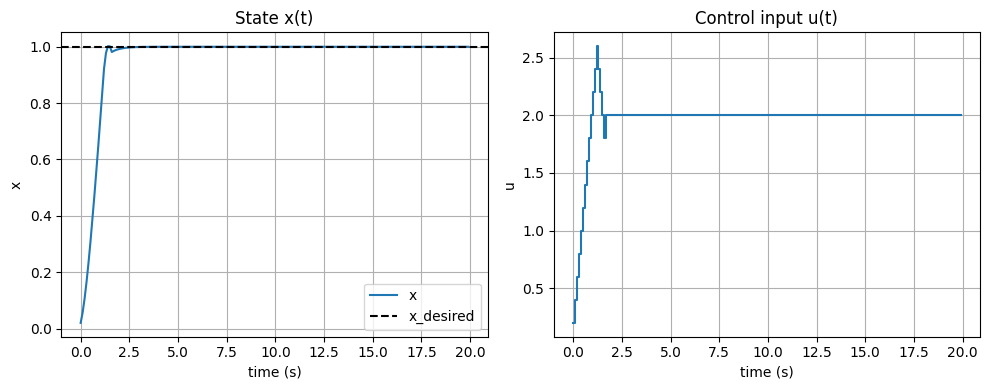

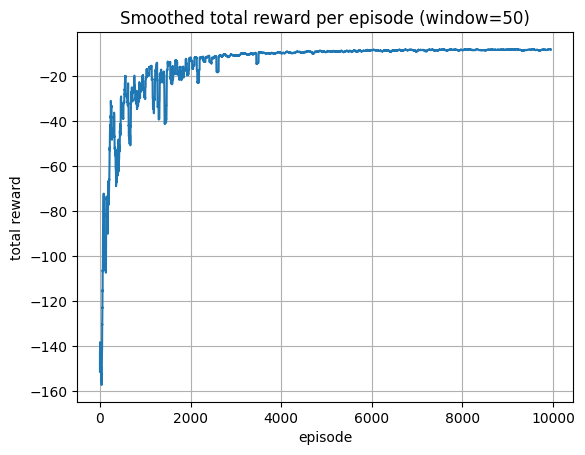

In [4]:
# test the learned policy
def run_episode(policy_greedy=True, render=False):
    x = 0.0
    u = 0.0
    traj = []
    for t in range(200):
        s = state_id(x, u)
        if policy_greedy:
            a = int(np.argmax(Q[s]))
        else:
            a = np.random.randint(n_actions)
        x, u = env_step(x, u, a)
        traj.append((t*dt, x, u, a))
    return np.array(traj, dtype=float)

traj = run_episode(policy_greedy=True)
ts, xs, us, acts = traj[:,0], traj[:,1], traj[:,2], traj[:,3]

# plots
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(ts, xs, label='x')
plt.axhline(x_desired, color='k', linestyle='--', label='x_desired')
plt.xlabel('time (s)'); plt.ylabel('x'); plt.title('State x(t)'); plt.grid(True); plt.legend()

plt.subplot(1,2,2)
plt.step(ts, us, where='post', label='u (control)')
plt.xlabel('time (s)'); plt.ylabel('u'); plt.title('Control input u(t)'); plt.grid(True)

plt.tight_layout()
plt.show()

# reward curve
plt.figure()
plt.plot(np.convolve(history, np.ones(50)/50, mode='valid'))
plt.title('Smoothed total reward per episode (window=50)')
plt.xlabel('episode'); plt.ylabel('total reward')
plt.grid(True)
plt.show()
